<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 6. Redes Neuronales Recurrentes</font></h1>

<h1><font color="#113D68" size=4>3. LSTM para Regresión</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. LSTM para regresión](#section1)
    * [1.1. Cargar el dataset](#section1.1)
    * [1.2. Normalización de datos](#section1.2)
    * [1.3. Train/Test](#section1.3)
    * [1.4. Creamos el dataset para una serie temporal](#section1.4)
    * [1.5. Transformar las muestras](#section1.5)
    * [1.6. Diseño de LSTM](#section1.6)
    * [1.7. Resultados](#section1.7)
* [2. LSTM usando ventana](#section2)
* [3. LSTM con pasos de tiempo](#section3)
* [4. LSTM con memoria entre batchs](#section4)
    * [4.1. Generar estado en train](#section4.1)
    * [4.2. Diseño de LSTM](#section4.2)
* [5. Stacked LSTM con memoria entre batchs](#section5)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

La red LSTM es un tipo de red neuronal recurrente que se utiliza en el Deep Learning porque se pueden entrenar con éxito arquitecturas muy grandes.

Por tanto, en esta lección trabajaremos:
* Desarrollar LSTM para un problema de regresión con secuencialidad temporal.
* Desarrollar redes LSTM usando una ventana y pasos de tiempo.
* Desarrollar y hacer predicciones que mantienen el estado (memoria) en secuencias muy largas.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. LSTM para regresión</font>

El problema que veremos en esta lección es el problema de predicción de pasajeros de aerolíneas internacionales.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre el dataset [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)

<a id="section1.1"></a>
# <font color="#004D7F" size=5>1.1. Cargar el dataset</font>

Cargamos el dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values
dataset= dataset.astype('float32')
print(dataset.shape)
print(dataset[0:5,:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(144, 1)
[[112.]
 [118.]
 [132.]
 [129.]
 [121.]]


<a id="section1.2"></a>
# <font color="#004D7F" size=5>1.2. Normalización de datos</font>

Las LSTM son sensibles a la escala de los datos de entrada, específicamente cuando se utilizan las funciones de activación Sigmoidea (predeterminada) o Tanh, por lo que una normalización nos otroga resultados más prometedores.

In [43]:
# normalize the dataset
scaler= MinMaxScaler(feature_range=(0,1))
dataset= scaler.fit_transform(dataset)
print(dataset.shape)
print(dataset[0:5,:])

(144, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


<a id="section1.3"></a>
# <font color="#004D7F" size=5>1.3. Train/Test</font>

Dividimos el conjunto de datos en train/test

In [44]:
# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape,test.shape)
print(train[0:5,:])

(96, 1) (48, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


<a id="section1.4"></a>
# <font color="#004D7F" size=5>1.4. Creamos el dataset para una serie temporal</font>

Utilizamos la funcion `create_dataset()` para adaptar nuestro dataset a una serie temporal

In [45]:
# reshape into X=t and Y=t+1
look_back= 1
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

print(trainX.shape, trainY.shape)
for i in range(5):
  print(trainX[i], trainY[i])

(94, 1) (94,)
[0.01544401] 0.027027026
[0.02702703] 0.05405405
[0.05405405] 0.04826255
[0.04826255] 0.032818526
[0.03281853] 0.059845567


<a id="section1.5"></a>
# <font color="#004D7F" size=5>1.5. Transformar las muestras</font>

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de: $[muestras,\ pasos\ de\ tiempo,\ características]$. 

Nuestros datos preparados tienen la forma: $[muestras,\ características]$ por lo que requiere esta transformación.

In [46]:
# reshape input to be [samples, time steps, features]
trainX= np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX= np.reshape(testX, (testX.shape[0],1,testX.shape[1]))

print(trainX.shape, testX.shape)

(94, 1, 1) (46, 1, 1)


<a id="section1.6"></a>
# <font color="#004D7F" size=5>1.6. Diseño de LSTM</font>

Creamos nuestra LSTM:
1. Una capa visible con 1 entrada
2. Una capa oculta con 4 bloques LSTM o neuronas
3. Una capa de salida que hace una predicción de valor único. LSTM utiliza por defecto la función Sigmoidal.
4. Entrenamos para 100 épocas y el tamaño de batch a 1.

In [47]:
# create and fit the LSTM network
model= Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam') 
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.0468
Epoch 2/100
94/94 - 0s - loss: 0.0239
Epoch 3/100
94/94 - 0s - loss: 0.0175
Epoch 4/100
94/94 - 0s - loss: 0.0158
Epoch 5/100
94/94 - 0s - loss: 0.0147
Epoch 6/100
94/94 - 0s - loss: 0.0140
Epoch 7/100
94/94 - 0s - loss: 0.0130
Epoch 8/100
94/94 - 0s - loss: 0.0121
Epoch 9/100
94/94 - 0s - loss: 0.0113
Epoch 10/100
94/94 - 0s - loss: 0.0105
Epoch 11/100
94/94 - 0s - loss: 0.0094
Epoch 12/100
94/94 - 0s - loss: 0.0084
Epoch 13/100
94/94 - 0s - loss: 0.0074
Epoch 14/100
94/94 - 0s - loss: 0.0064
Epoch 15/100
94/94 - 0s - loss: 0.0055
Epoch 16/100
94/94 - 0s - loss: 0.0046
Epoch 17/100
94/94 - 0s - loss: 0.0039
Epoch 18/100
94/94 - 0s - loss: 0.0032
Epoch 19/100
94/94 - 0s - loss: 0.0027
Epoch 20/100
94/94 - 0s - loss: 0.0025
Epoch 21/100
94/94 - 0s - loss: 0.0023
Epoch 22/100
94/94 - 0s - loss: 0.0022
Epoch 23/100
94/94 - 0s - loss: 0.0021
Epoch 24/100
94/94 - 0s - loss: 0.0021
Epoch 25/100
94/94 - 0s - loss: 0.0021
Epoch 26/100
94/94 - 0s - loss: 0.

<a id="section1.7"></a>
# <font color="#004D7F" size=5>1.7. Resultados</font>

A continuación se representa el cógido para representar los resultados.

In [48]:
# make predictions
trainPredict= model.predict(trainX)
testPredict= model.predict(testX)

# invert predictions
trainPredict= scaler.inverse_transform(trainPredict)
trainY= scaler.inverse_transform([trainY])
testPredict= scaler.inverse_transform(testPredict)
testY= scaler.inverse_transform([testY])

Train Score: 517.57 MSE (22.75 RMSE)
Test Score: 2366.02 MSE (48.64 RMSE)


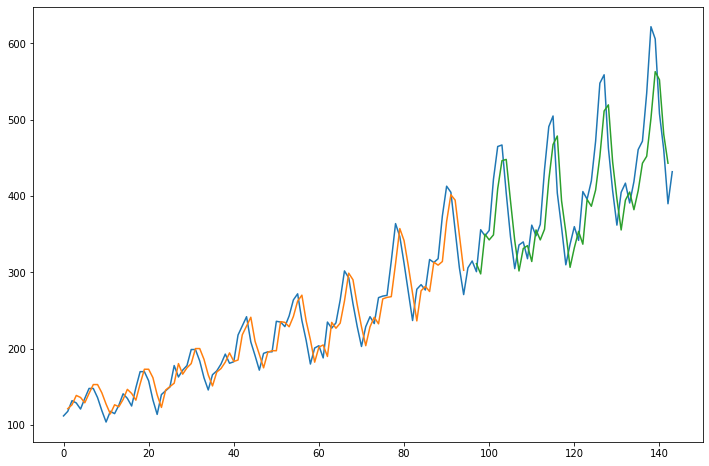

In [49]:
# calculate root mean squared error
trainScore= mean_squared_error(trainY[0],trainPredict[:,0])
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= mean_squared_error(testY[0],testPredict[:,0])
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Podemos ver que el modelo tiene un error promedio de aproximadamente 23 pasajeros (en miles) en el conjunto de datos de entrenamiento y aproximadamente 52 pasajeros (en miles) en el conjunto de datos de prueba. 

No está tan mal pero vamos a intentar mejorarlo

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. LSTM usando ventana</font>

Recordemos lo que estuviemos viendo, dado el tiempo actual _(t)_ que queremos predecir el valor en el próximo tiempo en la secuencia _(t + 1),_ podemos usar el tiempo actual _(t)_ así como los dos tiempos anteriores _(t-1_ y _t-2)_ como variables de entrada. Cuando se expresa como un problema de regresión, las variables de entrada son _t-2, t-1, t_ y la variable de salida es _t + 1._

Este proceso quedaría:
```
    X1  X2  X3  Y
    112 118 132 129
    118 132 129 121
    132 129 121 135
    129 121 135 148
    121 135 148 148 
```

Por tanto únicamente cambiamos el tamaño de ventana al proceso realizado anteriormente con la función `create_dataset()`.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values
dataset= dataset.astype('float32')

# normalize the dataset
scaler= MinMaxScaler(feature_range=(0,1))
dataset= scaler.fit_transform(dataset)

# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape,test.shape)
print(train[0:5,:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(96, 1) (48, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [52]:
# reshape into X=t and Y=t+1
look_back= 3
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX= np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX= np.reshape(testX, (testX.shape[0],1,testX.shape[1]))

# create and fit the LSTM network
model= Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') 
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)

Epoch 1/100
92/92 - 2s - loss: 0.0186
Epoch 2/100
92/92 - 0s - loss: 0.0075
Epoch 3/100
92/92 - 0s - loss: 0.0065
Epoch 4/100
92/92 - 0s - loss: 0.0058
Epoch 5/100
92/92 - 0s - loss: 0.0053
Epoch 6/100
92/92 - 0s - loss: 0.0048
Epoch 7/100
92/92 - 0s - loss: 0.0046
Epoch 8/100
92/92 - 0s - loss: 0.0043
Epoch 9/100
92/92 - 0s - loss: 0.0042
Epoch 10/100
92/92 - 0s - loss: 0.0041
Epoch 11/100
92/92 - 0s - loss: 0.0040
Epoch 12/100
92/92 - 0s - loss: 0.0039
Epoch 13/100
92/92 - 0s - loss: 0.0039
Epoch 14/100
92/92 - 0s - loss: 0.0038
Epoch 15/100
92/92 - 0s - loss: 0.0038
Epoch 16/100
92/92 - 0s - loss: 0.0037
Epoch 17/100
92/92 - 0s - loss: 0.0038
Epoch 18/100
92/92 - 0s - loss: 0.0036
Epoch 19/100
92/92 - 0s - loss: 0.0035
Epoch 20/100
92/92 - 0s - loss: 0.0035
Epoch 21/100
92/92 - 0s - loss: 0.0035
Epoch 22/100
92/92 - 0s - loss: 0.0034
Epoch 23/100
92/92 - 0s - loss: 0.0034
Epoch 24/100
92/92 - 0s - loss: 0.0033
Epoch 25/100
92/92 - 0s - loss: 0.0033
Epoch 26/100
92/92 - 0s - loss: 0.

Train Score: 479.64 MSE (21.90 RMSE)
Test Score: 3136.49 MSE (56.00 RMSE)


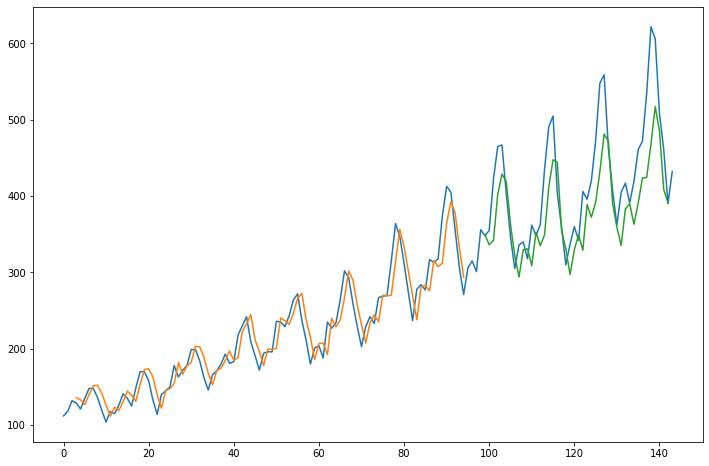

In [53]:
# make predictions
trainPredict= model.predict(trainX)
testPredict= model.predict(testX)

# invert predictions
trainPredict= scaler.inverse_transform(trainPredict)
trainY= scaler.inverse_transform([trainY])
testPredict= scaler.inverse_transform(testPredict)
testY= scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore= mean_squared_error(trainY[0],trainPredict[:,0])
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= mean_squared_error(testY[0],testPredict[:,0])
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. LSTM con pasos de tiempo</font>

En lugar de redactar las observaciones pasadas como características de entrada separadas, podemos usarlas como pasos de tiempo de la característica de una entrada, que de hecho es un encuadre más preciso del problema. Podemos hacer esto usando la misma representación de datos que en el ejemplo anterior basado en ventanas, excepto que cuando cambiamos la forma de los datos, configuramos las columnas para que sean la dimensión de pasos de tiempo y cambiamos la dimensión de características de nuevo a 1. 

```python
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values
dataset= dataset.astype('float32')

# normalize the dataset
scaler= MinMaxScaler(feature_range=(0,1))
dataset= scaler.fit_transform(dataset)

# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape,test.shape)
print(train[0:5,:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(96, 1) (48, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [55]:
# reshape into X=t and Y=t+1
look_back= 3
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])
print(trainX.shape)

# reshape input to be [samples, time steps, features]
trainX= np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX= np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

# create and fit the LSTM network
model= Sequential()
model.add(LSTM(4, input_shape=(look_back,1))) # cambia
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') 
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)

[0.01544401 0.02702703 0.05405405] 0.04826255
[0.02702703 0.05405405 0.04826255] 0.032818526
[0.05405405 0.04826255 0.03281853] 0.059845567
[0.04826255 0.03281853 0.05984557] 0.08494207
[0.03281853 0.05984557 0.08494207] 0.08494207
(92, 3)
(92, 3, 1)
Epoch 1/100
92/92 - 2s - loss: 0.0745
Epoch 2/100
92/92 - 0s - loss: 0.0344
Epoch 3/100
92/92 - 0s - loss: 0.0261
Epoch 4/100
92/92 - 0s - loss: 0.0229
Epoch 5/100
92/92 - 0s - loss: 0.0210
Epoch 6/100
92/92 - 0s - loss: 0.0195
Epoch 7/100
92/92 - 0s - loss: 0.0180
Epoch 8/100
92/92 - 0s - loss: 0.0164
Epoch 9/100
92/92 - 0s - loss: 0.0150
Epoch 10/100
92/92 - 0s - loss: 0.0137
Epoch 11/100
92/92 - 0s - loss: 0.0125
Epoch 12/100
92/92 - 0s - loss: 0.0112
Epoch 13/100
92/92 - 0s - loss: 0.0101
Epoch 14/100
92/92 - 0s - loss: 0.0089
Epoch 15/100
92/92 - 0s - loss: 0.0080
Epoch 16/100
92/92 - 0s - loss: 0.0070
Epoch 17/100
92/92 - 0s - loss: 0.0063
Epoch 18/100
92/92 - 0s - loss: 0.0056
Epoch 19/100
92/92 - 0s - loss: 0.0053
Epoch 20/100
92/9

Train Score: 675.43 MSE (25.99 RMSE)
Test Score: 4065.12 MSE (63.76 RMSE)


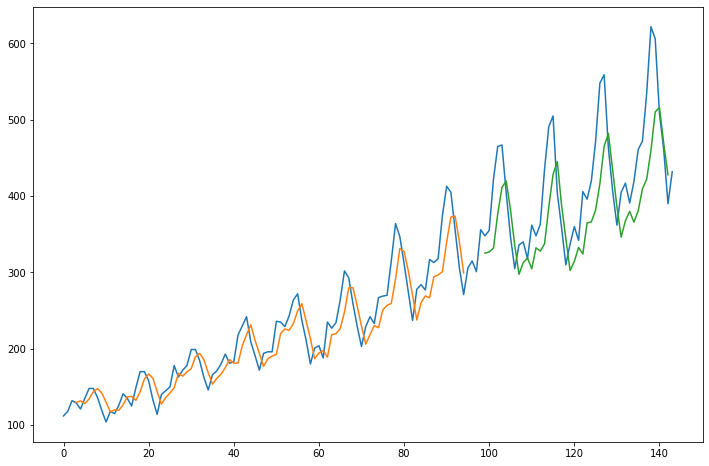

In [56]:
# make predictions
trainPredict= model.predict(trainX)
testPredict= model.predict(testX)

# invert predictions
trainPredict= scaler.inverse_transform(trainPredict)
trainY= scaler.inverse_transform([trainY])
testPredict= scaler.inverse_transform(testPredict)
testY= scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore= mean_squared_error(trainY[0],trainPredict[:,0])
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= mean_squared_error(testY[0],testPredict[:,0])
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. LSTM con memoria entre batchs</font>

La red LSTM tiene memoria que es capaz de recordar secuencias largas. 

<a id="section4.1"></a>
# <font color="#004D7F" size=5>4.1. Generar estado en train</font>

Normalmente, el estado dentro de la red se restablece después de cada batch, así como con cada llamada a `model.predict()` o `model.evaluate()`. Podemos obtener un control más preciso sobre cuándo se borra el estado interno de la red LSTM haciendo que la capa LSTM tenga estado (parámetro `stateful`). 

Por tanto, requerimos que los datos de entrenamiento no se mezclen al ajustar la red y un restablecimiento explícito del estado de la red después época mediante llamadas a la función `model.reset states()`.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values
dataset= dataset.astype('float32')

# normalize the dataset
scaler= MinMaxScaler(feature_range=(0,1))
dataset= scaler.fit_transform(dataset)

# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape,test.shape)
print(train[0:5,:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(96, 1) (48, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [58]:
# reshape into X=t and Y=t+1
look_back= 3
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])
print(trainX.shape)

# reshape input to be [samples, time steps, features]
trainX= np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX= np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

# create and fit the LSTM network
batch_size= 1

model= Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,look_back,1),stateful=True)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') 

for i in range(100):
  model.fit(trainX,trainY,epochs=1,batch_size=batch_size,verbose=2,shuffle=False)
  model.reset_states()


[0.01544401 0.02702703 0.05405405] 0.04826255
[0.02702703 0.05405405 0.04826255] 0.032818526
[0.05405405 0.04826255 0.03281853] 0.059845567
[0.04826255 0.03281853 0.05984557] 0.08494207
[0.03281853 0.05984557 0.08494207] 0.08494207
(92, 3)
(92, 3, 1)
92/92 - 1s - loss: 0.0174
92/92 - 0s - loss: 0.0177
92/92 - 0s - loss: 0.0126
92/92 - 0s - loss: 0.0096
92/92 - 0s - loss: 0.0076
92/92 - 0s - loss: 0.0064
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.

<a id="section4.2"></a>
# <font color="#004D7F" size=5>4.2. Diseño de LSTM</font>

Finalmente, cuando se construye la capa LSTM, el parámetro `stateful` debe establecerse en `True` y, en lugar de especificar,mediante el parámetro `batch_input_shape`:
1. Las dimensiones de entrada
2. Codificar el número de muestras en un batch
3. El número de pasos de tiempo en una muestra y 
4. El número de características en un paso de tiempo. 

Por ejemplo: 
```python
    model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
```

Este mismo tamaño de batch debe usarse más adelante al evaluar el modelo y hacer predicciones. 

```python
    model.predict(trainX, batch_size = batch_size)
```

Train Score: 651.28 MSE (25.52 RMSE)
Test Score: 4392.39 MSE (66.28 RMSE)


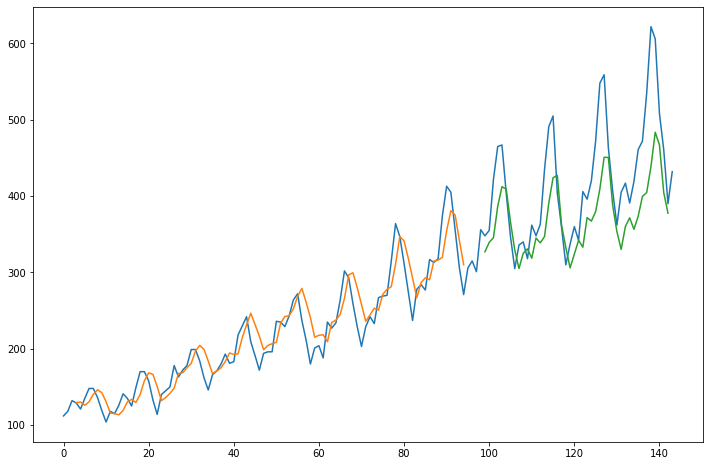

In [59]:
# make predictions
trainPredict= model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict= model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict= scaler.inverse_transform(trainPredict)
trainY= scaler.inverse_transform([trainY])
testPredict= scaler.inverse_transform(testPredict)
testY= scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore= mean_squared_error(trainY[0],trainPredict[:,0])
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= mean_squared_error(testY[0],testPredict[:,0])
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section5"></a>
# <font color="#004D7F" size=6>5. Stacked LSTM con memoria entre batchs</font>

Las redes LSTM se pueden apilar de la misma manera que se pueden apilar otros tipos de capas. Una adición a la configuración que se requiere es que una capa LSTM antes de cada capa LSTM subsiguiente debe devolver la secuencia. 

Esto se puede hacer configurando el parámetro `return_sequences` en la capa a `True`.

```python
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
```

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values
dataset= dataset.astype('float32')

# normalize the dataset
scaler= MinMaxScaler(feature_range=(0,1))
dataset= scaler.fit_transform(dataset)

# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape,test.shape)
print(train[0:5,:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(96, 1) (48, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [61]:
# reshape into X=t and Y=t+1
look_back= 3
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])
print(trainX.shape)

# reshape input to be [samples, time steps, features]
trainX= np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX= np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

# create and fit the LSTM network
batch_size= 1

model= Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,look_back,1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size,look_back,1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') 

for i in range(100):
  model.fit(trainX,trainY,epochs=1,batch_size=batch_size,verbose=2,shuffle=False)
  model.reset_states()

[0.01544401 0.02702703 0.05405405] 0.04826255
[0.02702703 0.05405405 0.04826255] 0.032818526
[0.05405405 0.04826255 0.03281853] 0.059845567
[0.04826255 0.03281853 0.05984557] 0.08494207
[0.03281853 0.05984557 0.08494207] 0.08494207
(92, 3)
(92, 3, 1)
92/92 - 3s - loss: 0.0053
92/92 - 0s - loss: 0.0144
92/92 - 0s - loss: 0.0099
92/92 - 0s - loss: 0.0077
92/92 - 0s - loss: 0.0065
92/92 - 0s - loss: 0.0060
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.

Train Score: 456.75 MSE (21.37 RMSE)
Test Score: 5020.14 MSE (70.85 RMSE)


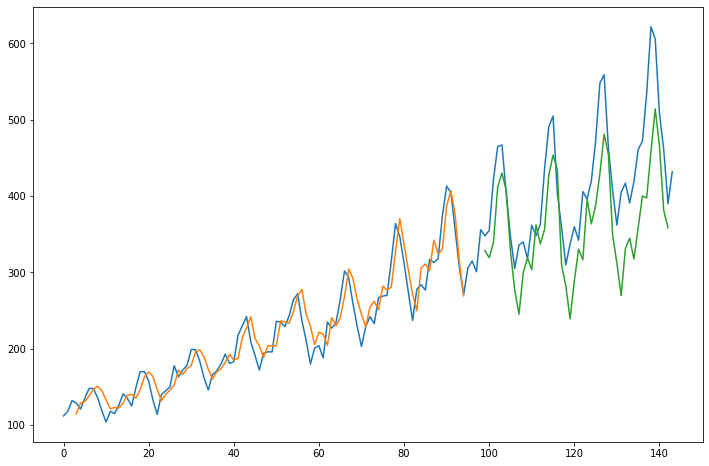

In [62]:
# make predictions
trainPredict= model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict= model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict= scaler.inverse_transform(trainPredict)
trainY= scaler.inverse_transform([trainY])
testPredict= scaler.inverse_transform(testPredict)
testY= scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore= mean_squared_error(trainY[0],trainPredict[:,0])
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= mean_squared_error(testY[0],testPredict[:,0])
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>